In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# adfuller test
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)  # p<0.05, Stationary

In [3]:
ten_stocks_close = pd.read_csv('close_df.csv')

In [4]:
pool = ["600094.XSHG",    
        "600160.XSHG", 
        "600008.XSHG",
        "600903.XSHG",
        "000959.XSHE",
        "600970.XSHG",
        "002302.XSHE",
        "600823.XSHG",
        "002503.XSHE",
        "600664.XSHG"]

In [5]:
close_price = ten_stocks_close['600970.XSHG'].dropna()

## Ljung Box Test on close price

In [6]:
import statsmodels.api as sm
sm.stats.acorr_ljungbox(close_price, lags=[12], return_df=True) # The p-value closes to 0. Has dependency

,lb_stat,lb_pvalue
12,13812.41786,0.0


## Stationarity on close price first

In [7]:
test_stationarity(close_price) # p-value is larger than 0.05. Has unit root

Results of Dickey-Fuller Test:
Test Statistic                   -3.002097
p-value                           0.034699
#Lags Used                       14.000000
Number of Observations Used    1411.000000
Critical Value (1%)              -3.434993
Critical Value (5%)              -2.863591
Critical Value (10%)             -2.567862
dtype: float64


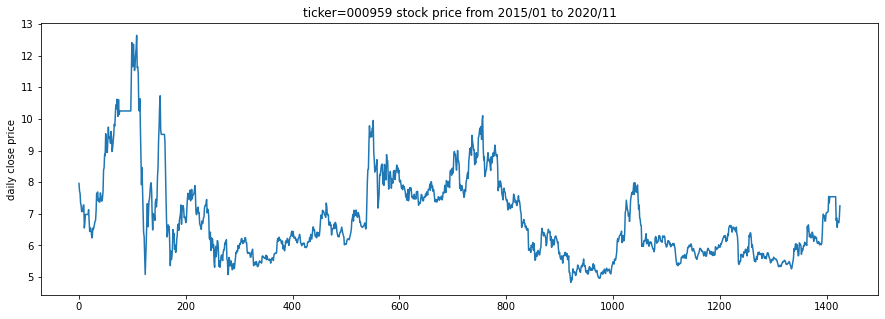

In [8]:
# visualize daily close data, lable y = column 1, ticker = 600094
close_price.plot(figsize=(15,5))
plt.ylabel('daily close price')
plt.title('ticker=000959 stock price from 2015/01 to 2020/11')
plt.show()

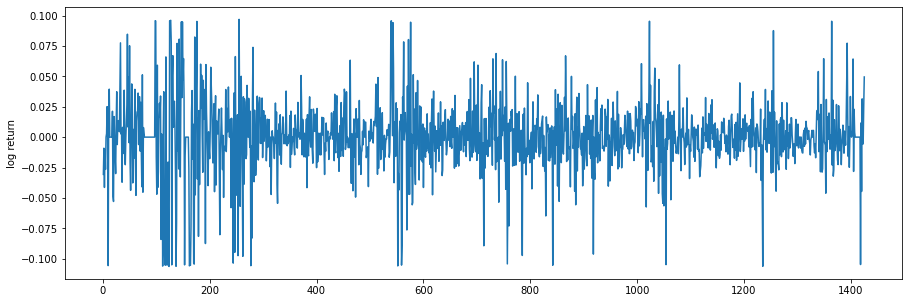

In [9]:
log_rtn = np.log(close_price).diff(1).dropna()
log_rtn.plot(figsize=(15,5))
plt.ylabel('log return')
plt.show()

## Test stationarity

In [10]:
test_stationarity(log_rtn) #p-value is small, it's stationary

Results of Dickey-Fuller Test:
Test Statistic                -1.214942e+01
p-value                        1.582892e-22
#Lags Used                     1.100000e+01
Number of Observations Used    1.413000e+03
Critical Value (1%)           -3.434986e+00
Critical Value (5%)           -2.863588e+00
Critical Value (10%)          -2.567860e+00
dtype: float64


## ACF & PACF

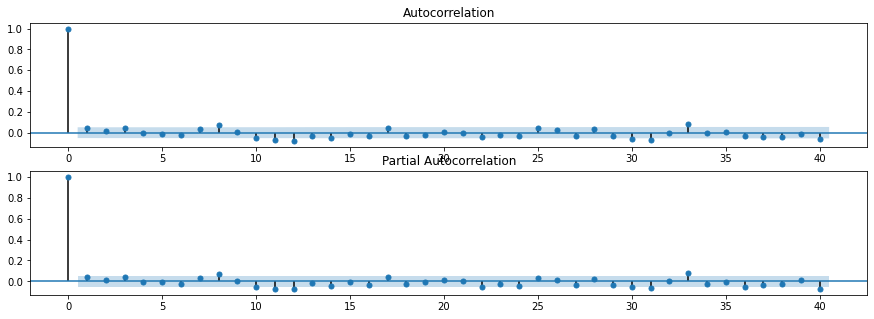

In [11]:
# acf & pacf for log return
import statsmodels.api as sm
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(log_rtn, lags=40, ax=ax1) 
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(log_rtn, lags=40, ax=ax2)

## Distribution of log return

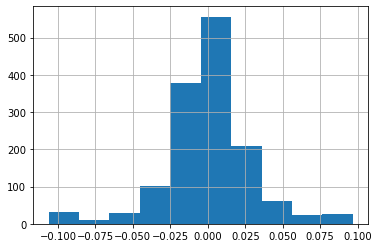

In [12]:
log_rtn.hist()
plt.show()

## Fit ARMA Model

In [13]:
import pandas as pd
import itertools
import warnings
warnings.filterwarnings("ignore")

from statsmodels.tsa.arima_model import ARIMA

p = range(5)
q = range(5)

combinations = list(itertools.product(p, q))
combinations = combinations[1:] # Drop (0,0)
def train_ARMA(param):
    try:
        p = param[0]
        q = param[1]
        model = ARIMA(log_rtn, order=(p,0,q))

        model_fit = model.fit(disp=0)

        ljung_p = sm.stats.acorr_ljungbox(model_fit.resid, lags=[12-p-q], return_df=True).values[0][1]
        aic = model_fit.aic
        return {'p': p, 'q': q, 'ljung_p': ljung_p, 'aic': aic}
    except:
        print(param)

results = pd.DataFrame(columns=['p', 'q', 'ljung_p', 'aic'])
for pq in combinations:
    results = results.append(train_ARMA(pq), ignore_index=True) 

results[results['ljung_p']>=0.05].sort_values(by=['aic'])

,p,q,ljung_p,aic
17,3.0,3.0,0.969711,-6014.412814
16,3.0,2.0,0.919188,-6013.381400
18,3.0,4.0,0.953287,-6012.482309
22,4.0,3.0,0.952945,-6012.480849
8,1.0,4.0,0.875271,-6009.803727
20,4.0,1.0,0.854117,-6009.529759
23,4.0,4.0,0.952101,-6009.125597
13,2.0,4.0,0.994716,-6007.835298
21,4.0,2.0,0.991038,-6007.647149
5,1.0,1.0,0.091695,-6003.353003


## GARCH

In [14]:
mean = log_rtn.mean() # The mean closes to 0

### Check if volatility time dependency

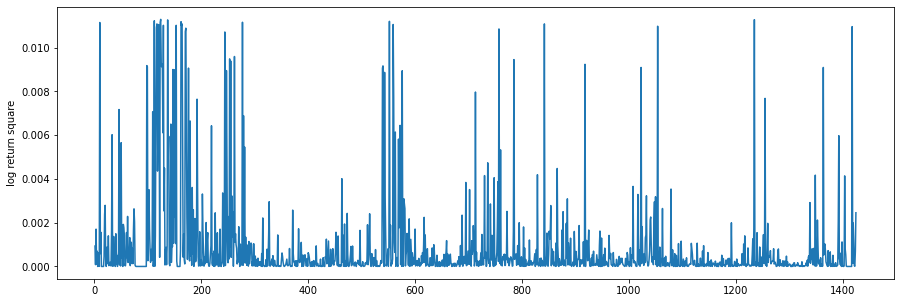

In [15]:
#log return square 
log_rtn_square = np.square(log_rtn - mean)
log_rtn_square.plot(figsize=(15,5))
plt.ylabel('log return square')
plt.show()

In [16]:
import statsmodels.api as sm

p_2 = sm.stats.acorr_ljungbox(log_rtn_square, lags=[40], return_df=True)['lb_pvalue'].values[0] # log return square is white noise if p < 0.05

print(f"P-value for squared log return: {p_2}")
if (p_2<0.05):
    print("Conclusion: Has ARCH's property in log rtn")
else:
    print("Conclusion: No ARCH's property in log rtn")

P-value for squared log return: 0.0
Conclusion: Has ARCH's property in log rtn


In [18]:
from arch.univariate import arch_model
import itertools
import warnings
warnings.filterwarnings("ignore")

p = range(1,4)
q = range(1,4)

combinations = list(itertools.product(p, q))

def train_GARCH(param):
    p = param[0]
    q = param[1]
    model = arch_model(log_rtn, mean='constant', p=p, q=q)
    
    res = model.fit(update_freq=0)
    
    ljung_p = sm.stats.acorr_ljungbox(res.std_resid, lags=[12], return_df=True).values[0][1]
    aic = res.aic
    
    return {'p':p, 'q': q, 'alpha': res.params['alpha[1]'], 'beta': res.params['beta[1]'], 'ljung_p': ljung_p, 'aic': aic}

results = pd.DataFrame(columns=['p', 'q', 'alpha', 'beta', 'ljung_p', 'aic'])
for pq in combinations:
    results = results.append(train_GARCH(pq), ignore_index=True) 

results[results['ljung_p']>=0.05].sort_values(by=['aic']) # No GARCH models are satisfactory

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3185.852358517548
            Iterations: 6
            Function evaluations: 17
            Gradient evaluations: 2
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3196.1614361227817
            Iterations: 15
            Function evaluations: 118
            Gradient evaluations: 15
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3194.5333183918992
            Iterations: 14
            Function evaluations: 126
            Gradient evaluations: 10
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3181.2298561896723
            Iterations: 8
            Function evaluations: 50
            Gradient evaluations: 4
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3189.618118576136
            Iterations: 2
            Function eva

,p,q,alpha,beta,ljung_p,aic
1,1.0,2.0,0.115754,0.129795,0.342732,-6382.322872
2,1.0,3.0,0.099972,0.293250,0.286062,-6377.066637
4,2.0,2.0,0.050000,0.440000,0.282196,-6367.236237
0,1.0,1.0,0.050000,0.930000,0.218479,-6363.704717
5,2.0,3.0,0.050132,0.293292,0.248026,-6362.390656
7,3.0,2.0,0.033334,0.440000,0.267505,-6359.986080
8,3.0,3.0,0.033344,0.293330,0.234358,-6356.398994
3,2.0,1.0,0.025000,0.930000,0.193227,-6352.459712
6,3.0,1.0,0.016667,0.929999,0.183473,-6345.729610


## EGARCH

In [19]:
from arch.univariate import arch_model
import itertools
import warnings
warnings.filterwarnings("ignore")

p = range(1,4)
q = range(1,4)

combinations = list(itertools.product(p, q))

def train_EGARCH(param):
    p = param[0]
    q = param[1]
    model = arch_model(log_rtn, vol='EGARCH', mean='constant', p=p, q=q, dist='t')
    
    res = model.fit(update_freq=0)
    
    ljung_p = sm.stats.acorr_ljungbox(res.std_resid, lags=[12], return_df=True).values[0][1]
    aic = res.aic
    return {'p':p, 'q': q, 'params': res.params, 'ljung_p': ljung_p, 'aic': aic}

results = pd.DataFrame(columns=['p', 'q', 'params', 'ljung_p', 'aic'])

for pq in combinations:
    try:
        results = results.append(train_EGARCH(pq), ignore_index=True)
    except:
        continue

results[results['ljung_p']>=0.05].sort_values(by=['aic'])

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3302.958888915212
            Iterations: 24
            Function evaluations: 192
            Gradient evaluations: 24
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3303.251254506139
            Iterations: 28
            Function evaluations: 239
            Gradient evaluations: 28
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3303.491230184076
            Iterations: 35
            Function evaluations: 343
            Gradient evaluations: 35
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3303.3091684173287
            Iterations: 29
            Function evaluations: 267
            Gradient evaluations: 29
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3303.309301112752
            Iterations: 30
            Functio

,p,q,params,ljung_p,aic
0,1,1,mu 2.065957e-08 omega -1.345991e...,0.592138,-6595.917778
3,2,1,mu 1.444200e-08 omega -1.259432e...,0.603372,-6594.618337
1,1,2,mu 7.468564e-09 omega -1.440469e...,0.603072,-6594.502509
2,1,3,mu 3.336063e-09 omega -1.508838e...,0.610916,-6592.982460
6,3,1,mu 2.023569e-08 omega -1.245812e...,0.602925,-6592.796841
4,2,2,mu 1.337029e-08 omega -1.262396e...,0.603798,-6592.618602
5,2,3,mu 6.678689e-09 omega -2.746629e...,0.622535,-6592.163128
7,3,2,mu 1.738553e-10 omega -2.356470e...,0.582061,-6591.843110
8,3,3,mu 5.198374e-10 omega -3.206645e...,0.613485,-6590.381949
